In [2]:
import os
import pandas as pd
import numpy as np
from typing import Union, List, Literal
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
from Helper_Util import *

In [4]:
Filepath = '/content/drive/MyDrive/QoS Prediction Challenge by ITU ML in 5G Challenge'
pd.set_option('display.max_colwidth',200)

In [5]:
def Load_Data(file_path: str) -> List[pd.DataFrame]:
  train = pd.read_csv(file_path+'/Train.csv')
  test = pd.read_csv(file_path+'/Test.csv')
  sub = pd.read_csv(file_path+'/SampleSubmission.csv')
  variables = pd.read_csv(file_path+'/VariableDefinitions.csv')

  return train, test, sub, variables


In [6]:
Train, Test, Sub, Variables = Load_Data(Filepath)

### Data Exploration

In [ ]:
Train.head(3)

,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
0,Id_qt2qn56050,1624367008,pc1,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,...,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,Residential,51500000.0
1,Id_f1zf07cwb6,1624372465,pc3,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,Residential,50300000.0
2,Id_uoxdz7di5b,1624371871,pc3,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,...,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,Residential,16500000.0


In [ ]:
Test.head(3)

,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,apparentTemperature,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area
0,Id_ln0e0hfrgx,1624374179,pc2,-97.121875,-12.923750,-87.554375,13.293,39276.0,24.0,20,...,23.05,14.55,0.59,1013.6,2.27,0.83,3.0,16.093,3.07702,Avenue
1,Id_svf7nz9fxv,1624366264,pc4,-65.202500,-9.944375,-35.501875,21.823,39566.0,25.0,20,...,21.56,13.92,0.62,1013.6,2.42,0.95,4.0,16.093,0.66000,Park
2,Id_ww2mh07gwj,1624375795,pc2,-79.298125,-17.468750,-74.823750,24.114,41900.0,27.0,20,...,22.93,14.65,0.60,1013.5,2.26,0.85,3.0,16.093,2.49330,Park


In [ ]:
Train.select_dtypes(include=['object']).columns
Test.select_dtypes(include=['object']).columns

Index(['id', 'device', 'area'], dtype='object')

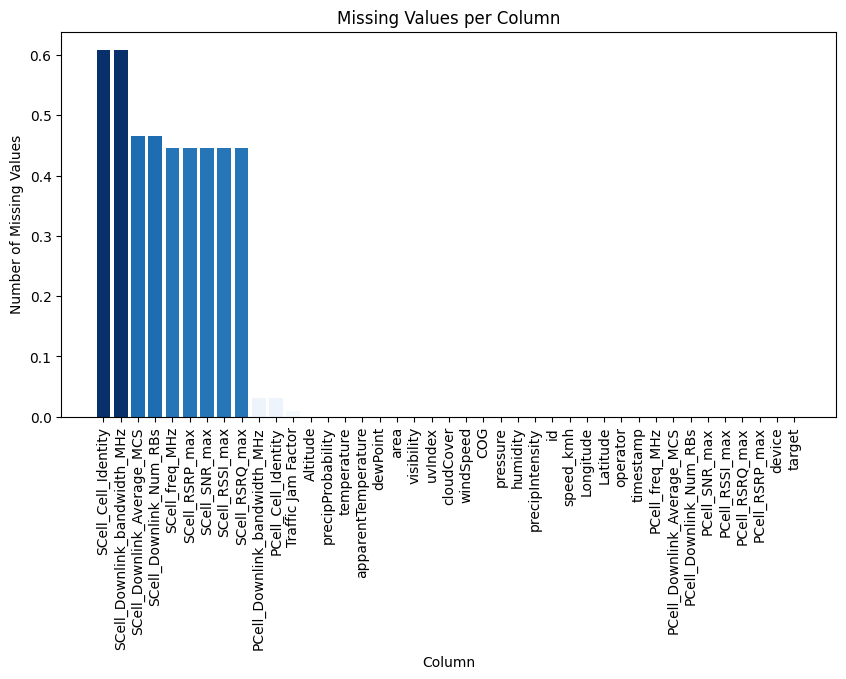

In [ ]:
missing_values = Train.isna().sum()/ Train.shape[0]
missing_values = missing_values.sort_values(ascending=False)


# Normalize the data to be between 0 and 1
norm = plt.Normalize(missing_values.values.min(), missing_values.values.max())
# Create a colormap
cmap = cm.ScalarMappable(norm=norm, cmap='Blues')
# Generate colors for each bar
colors = [cmap.to_rgba(val) for val in missing_values.values]

# Create bar plot of missing values
plt.figure(figsize=(10,5))
plt.bar(missing_values.index, missing_values.values, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values per Column')
plt.show()



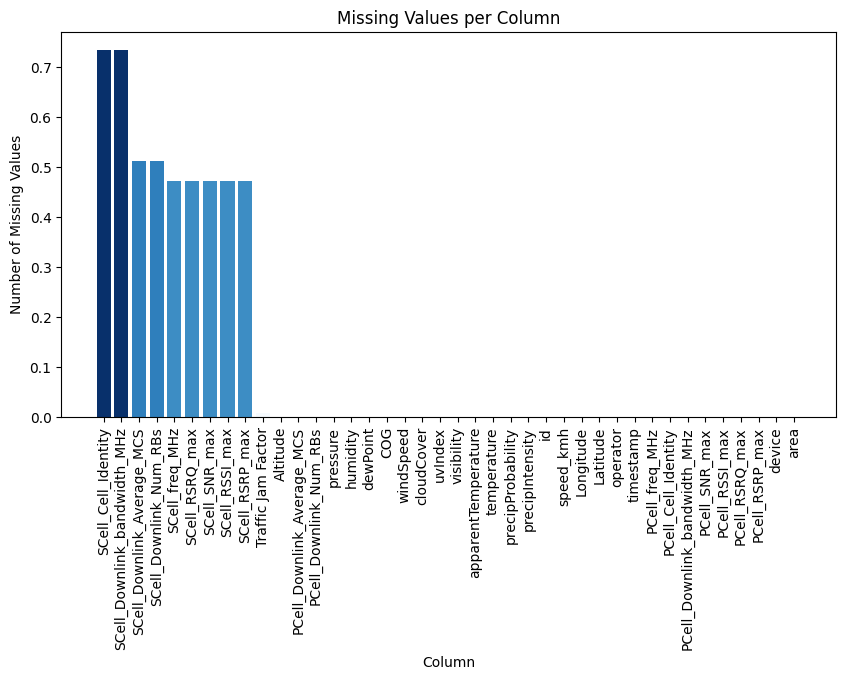

In [ ]:
missing_values = Test.isna().sum()/ Test.shape[0]
missing_values = missing_values.sort_values(ascending=False)
import matplotlib.cm as cm

# Normalize the data to be between 0 and 1
norm = plt.Normalize(missing_values.values.min(), missing_values.values.max())
# Create a colormap
cmap = cm.ScalarMappable(norm=norm, cmap='Blues')
# Generate colors for each bar
colors = [cmap.to_rgba(val) for val in missing_values.values]

# Create bar plot of missing values
plt.figure(figsize=(10,5))
plt.bar(missing_values.index, missing_values.values, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values per Column')
plt.show()

SCELLS_ have the most missing values

###Baseline Score

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from abc import ABC, abstractmethod
import random

In [8]:
!pip install catboost -q
from catboost import CatBoostRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.0 MB/s eta 0:00:00


In [9]:
Sscaler = StandardScaler()
Mmscaler = MinMaxScaler()
rfr = RandomForestRegressor()
xgb = XGBRegressor()
cbc = CatBoostRegressor()
lgb = LGBMRegressor()
mse = mean_squared_error

In [10]:
class Baseline_score():
  def __init__(
      self,
      train: pd.DataFrame,
      model: Union[XGBRegressor, LGBMRegressor, CatBoostRegressor,RandomForestRegressor],
      scaler: Union[StandardScaler, MinMaxScaler, None] = None,
      split_method: Literal["KFold", "train_test_split"] = "KFold",
      num_split = 5,
      random_seed = 42,
      VERBOSE: Literal[True,False] = False
  ):
    if not isinstance(model, (XGBRegressor, LGBMRegressor, CatBoostRegressor,RandomForestRegressor)):
      raise TypeError("model must be a class of either XGBRegressor, LGBMRegressor, CatBoostRegressor, or LinearRegression")
    if scaler is not None and not isinstance(scaler, (StandardScaler, MinMaxScaler)):
        raise TypeError("scaler must be a class of either StandardScaler, MinMaxScaler or None")
    if not isinstance(train, pd.DataFrame):
      raise TypeError("train must be a DataFrame")

    self.train = train
    self.model = model
    self.scaler = scaler
    self.split = split_method
    self.num_split = num_split
    self.seed = random_seed
    self.VERBOSE = VERBOSE
    self.feature_importances = None
    random.seed(random_seed)
    np.random.seed(random_seed)

  def run(self)-> float:
    X = self.train.iloc[:,:-1]
    self.feature_importances = np.zeros(X.shape[1])
    y = self.train.iloc[:,-1]

    if self.split == "train_test_split":
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=self.seed)
      if self.scaler != None:
        X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)
      if isinstance(self.model, CatBoostRegressor):
        self.model.fit(X_train,y_train,verbose=False)
      else:
        self.model.fit(X_train,y_train)
      self.feature_importances += self.model.feature_importances_
      preds = self.model.predict(X_test)
      if self.VERBOSE:
        print(f"split: {(self.split).upper()}")
        print(f"RMSE {mean_squared_error(y_test,preds,squared=False)}")
        print(f"MAE {mean_absolute_error(y_test,preds)}")
        print(f"MSE {mean_squared_error(y_test,preds)}")
      score = mean_squared_error(y_test,preds,squared=False)
      return score

    else:
      fold = KFold(n_splits=self.num_split)
      oof_f1 = []
      i = 1
      for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index],X.iloc[test_index]
        y_train, y_test = y.iloc[train_index],y.iloc[test_index]
        if self.scaler != None:
          X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)
        if isinstance(self.model, CatBoostRegressor):
          self.model.fit(X_train,y_train,verbose=False)
        else:
          self.model.fit(X_train,y_train)
        self.feature_importances += self.model.feature_importances_
        preds=self.model.predict(X_test)
        if self.VERBOSE:
          print(f"split {self.split}{i}")
          print(f"RMSE {mean_squared_error(y_test,preds,squared=False)}")
          print(f"MAE {mean_absolute_error(y_test,preds)}")
          print(f"MSE {mean_squared_error(y_test,preds)}\n")
        oof_f1.append(mean_squared_error(y_test,preds,squared=False))
        i += 1

      self.feature_importances = self.feature_importances / self.num_split
      score = sum(oof_f1)/self.num_split
      return score

  def plot_features(self):
    X = self.train.iloc[:,:-1]
    features = pd.DataFrame({'feature': list(X.columns),
                             'importance': self.feature_importances}).sort_values('importance', ascending = True)
    norm = plt.Normalize(features['importance'].min(), features['importance'].max())
    cmap = cm.ScalarMappable(norm=norm, cmap='Reds')
    colors = [cmap.to_rgba(val) for val in features['importance'].values]
    plt.figure(figsize=(25,10))
    plt.barh(features['feature'],features['importance'], color=colors)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.show()




In [11]:
class Baseline_predict(Baseline_score):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.preds = None

  def predict(self, test):
    X = self.train.iloc[:,:-1]
    y = self.train.iloc[:,-1]

    if self.split == "train_test_split":
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=self.seed)
      if self.scaler != None:
        X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)
      if isinstance(self.model, CatBoostRegressor):
        self.model.fit(X_train,y_train,verbose=False)
      else:
        self.model.fit(X_train,y_train)
      self.preds = self.model.predict(test)
      print(f"split: {(self.split).upper()}")
      return self.preds

    else:
      fold = KFold(n_splits=self.num_split)
      oof_preds = []
      i = 1
      for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index],X.iloc[test_index]
        y_train, y_test = y.iloc[train_index],y.iloc[test_index]
        if self.scaler != None:
          X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)
        if isinstance(self.model, CatBoostRegressor):
          self.model.fit(X_train,y_train,verbose=False)
        else:
          self.model.fit(X_train,y_train)
        pred=self.model.predict(test)
        if self.VERBOSE:
          print(f"split {self.split}{i}")
        oof_preds.append(pred)
        i += 1

      self.preds = oof_preds
      return self.preds

  def submission(self, test):
    pres = self.preds
    if self.split == 'KFold':
      final_preds = sum(pres)/self.num_split
    else:
      final_preds = pres
    predictions_df = pd.DataFrame({'id': test.id, 'target': final_preds})
    return predictions_df




In [12]:
TT = Train.drop(['id','device'],axis=1)
tests = Test.drop(['id','device'], axis=1)
#TT['device'] = TT['device'].map({'pc1':1,'pc3':2})
#TT['area'] = TT['area'].map({'Residential':1,'Avenue':2,'Park':3,'Highway':4,'Tunnel':5})
categorical_features = ['area']
oe = OrdinalEncoder()
tests['area'] = oe.fit_transform(tests[['area']])
TT['area'] = oe.fit_transform(TT[['area']])
tests.fillna(0, inplace=True)
TT.fillna(0, inplace=True)

In [19]:
Baseline = Baseline_score(train=TT,model=cbc,split_method='train_test_split',num_split=5,VERBOSE=False,random_seed=0)
lgb_score = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

split: TRAIN_TEST_SPLIT
RMSE 9179345.782428382
MAE 5819329.424974657
MSE 84260388993385.72
CV_RMSE_Score:9179345.782428382


In [20]:
predictions = Baseline_predict(train=TT,model=cbc,split_method='train_test_split',VERBOSE=False,random_seed=0)
predict = predictions.predict(tests)
preds = predictions.submission(Test)

split: TRAIN_TEST_SPLIT


In [12]:
Test['target'] = 'Test'
data = pd.concat([Train,Test]).reset_index(drop=True)

###Data Visualization


In [23]:
data.head(3)

,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
0,Id_qt2qn56050,1624367008,pc1,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,...,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,Residential,51500000.0
1,Id_f1zf07cwb6,1624372465,pc3,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,Residential,50300000.0
2,Id_uoxdz7di5b,1624371871,pc3,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,...,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,Residential,16500000.0


In [24]:
Variables

,VARIABLENAME,VARIABLE DESCRIPTION
0,id,Unique ID for each row
1,timestamp,Unix timestamp in seconds
2,device,ID of the vehicle carrying the UE
3,PCell_RSRP_max,Maximum reference signal received power in dBm from the primary cell
4,PCell_RSRQ_max,Maximum reference signal received quality in dB from the primary cell
5,PCell_RSSI_max,Maximum received signal strength indicator in dBm from the primary cell
6,PCell_SNR_max,Maximum signal to noise ratio in dB from the primary cell
7,PCell_Downlink_Num_RBs,Aggregated number of received resource blocks in downlink from the primary cell
8,PCell_Downlink_TB_Size,Aggregated transport block size in downlink from the primary cell
9,PCell_Downlink_Average_MCS,Average modulation and coding scheme weighted by received resource blocks from the primary cell


In [25]:
Vard = Variables.set_index('VARIABLENAME').T

In [26]:
Vard[data.filter(like="PCell").columns]

VARIABLENAME,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz
VARIABLE DESCRIPTION,Maximum reference signal received power in dBm from the primary cell,Maximum reference signal received quality in dB from the primary cell,Maximum received signal strength indicator in dBm from the primary cell,Maximum signal to noise ratio in dB from the primary cell,Aggregated number of received resource blocks in downlink from the primary cell,Average modulation and coding scheme weighted by received resource blocks from the primary cell,Downlink bandwidth in MHz from the primary cell,Cell ID of the primary cell,Carrier frequency in MHz of the primary cell


In [27]:
data[['PCell_Downlink_Average_MCS','PCell_SNR_max','PCell_Downlink_Num_RBs']].describe()

,PCell_Downlink_Average_MCS,PCell_SNR_max,PCell_Downlink_Num_RBs
count,52516.000000,52517.000000,52516.000000
mean,19.870363,11.723725,61651.730958
std,5.311899,7.373065,23571.844794
min,0.000000,-15.603000,4.000000
25%,16.000000,6.523000,42225.250000
50%,20.000000,11.856000,54143.500000
75%,24.000000,17.500000,86717.250000
max,28.000000,28.958000,100580.000000


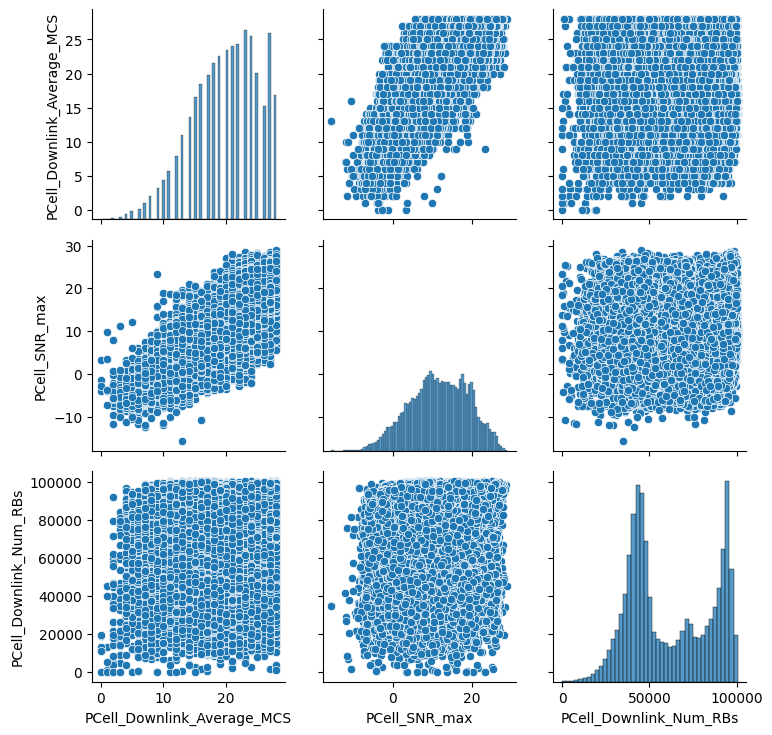

In [28]:
g = sns.PairGrid(data[['PCell_Downlink_Average_MCS','PCell_SNR_max','PCell_Downlink_Num_RBs']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

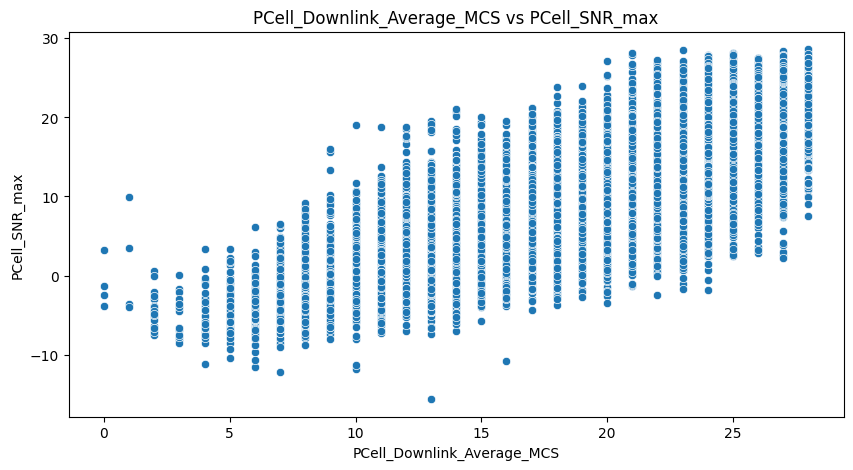

In [29]:
scatterplot(x=Train['PCell_Downlink_Average_MCS'],y=Train['PCell_SNR_max'])

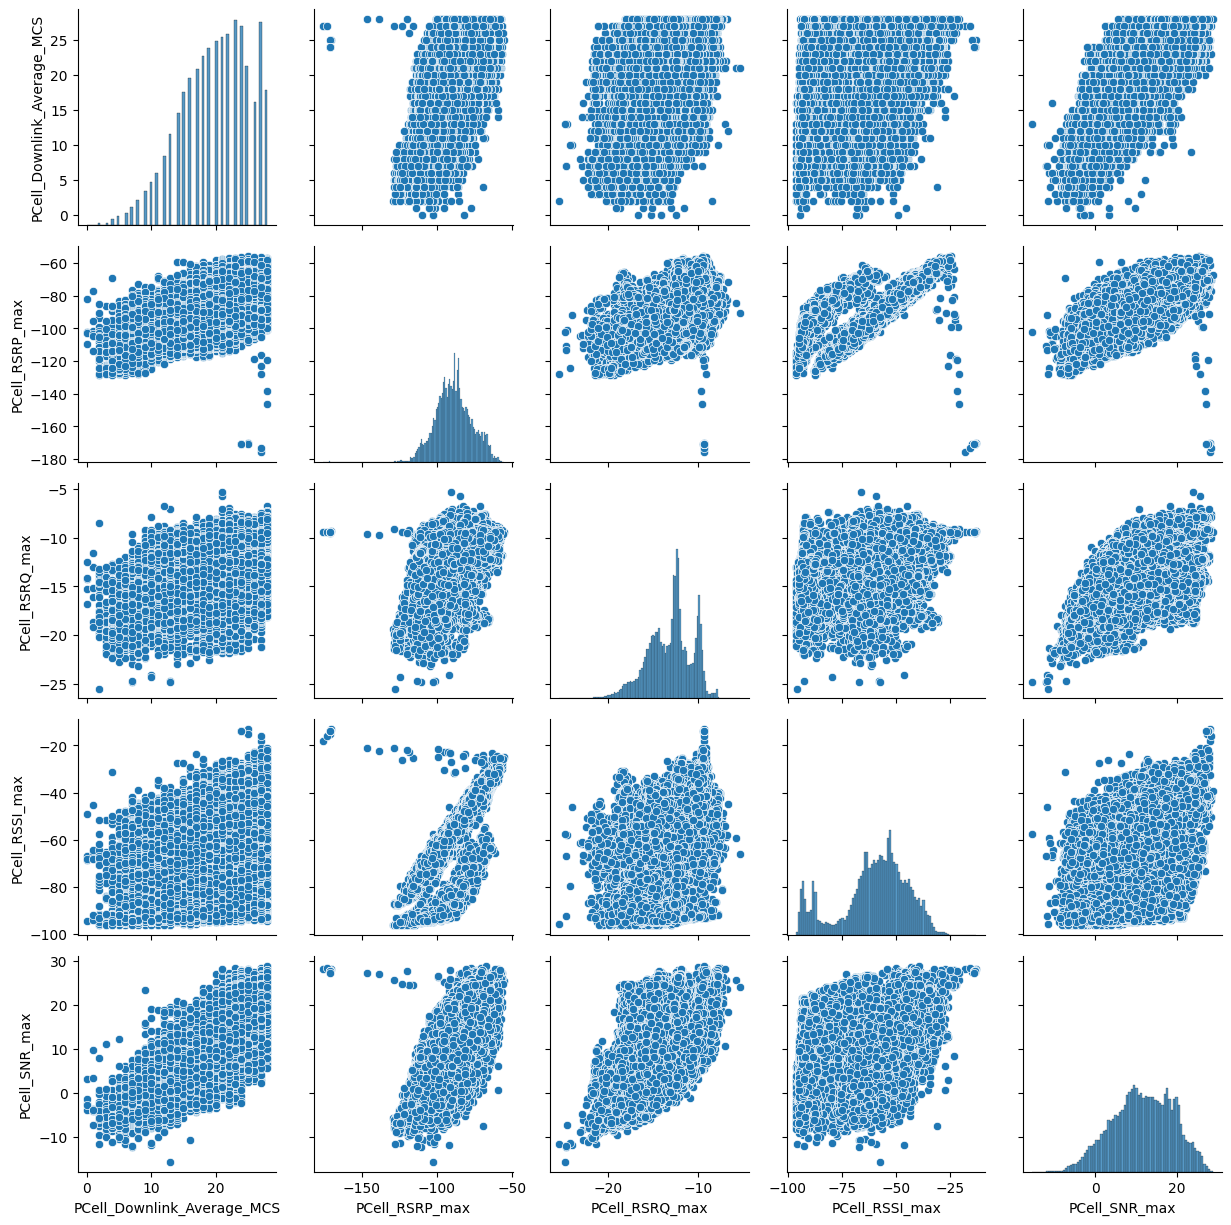

In [30]:
g = sns.PairGrid(data[['PCell_Downlink_Average_MCS','PCell_RSRP_max','PCell_RSRQ_max','PCell_RSSI_max','PCell_SNR_max']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

In [31]:
data[['PCell_RSRP_max','PCell_RSRQ_max','PCell_RSSI_max']].describe()

,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max
count,52517.000000,52517.000000,52517.000000
mean,-88.808839,-13.162359,-60.304413
std,11.805502,2.448779,15.577579
min,-175.605625,-25.439212,-96.388462
25%,-96.614375,-14.837500,-67.576250
50%,-88.872500,-12.774375,-57.936813
75%,-81.142500,-11.512500,-49.588125
max,-55.550625,-5.389375,-13.032500


In [32]:
data[['PCell_Downlink_Average_MCS','PCell_RSRP_max','PCell_RSRQ_max','PCell_RSSI_max','PCell_SNR_max']].head(3)

,PCell_Downlink_Average_MCS,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max
0,23.0,-84.498750,-14.586875,-49.855625,16.457
1,24.0,-86.818125,-11.982500,-54.838125,16.674
2,22.0,-101.916250,-13.257500,-71.241250,9.392


In [33]:
data[['SCell_SNR_max','SCell_Downlink_Num_RBs','SCell_Cell_Identity','SCell_RSRQ_max']].describe()

,SCell_SNR_max,SCell_Downlink_Num_RBs,SCell_Cell_Identity,SCell_RSRQ_max
count,28640.000000,27228.000000,1.828500e+04,28640.000000
mean,12.198950,66503.163875,2.370601e+07,-11.610701
std,7.133192,24275.574863,1.320025e+07,2.827780
min,-17.950000,1.000000,2.568966e+06,-30.000000
25%,7.762000,46800.000000,2.634752e+07,-12.560000
50%,13.070000,66320.000000,2.660711e+07,-10.584062
75%,17.045000,91544.000000,3.082880e+07,-9.810625
max,28.478000,99516.000000,5.184257e+07,-6.457849


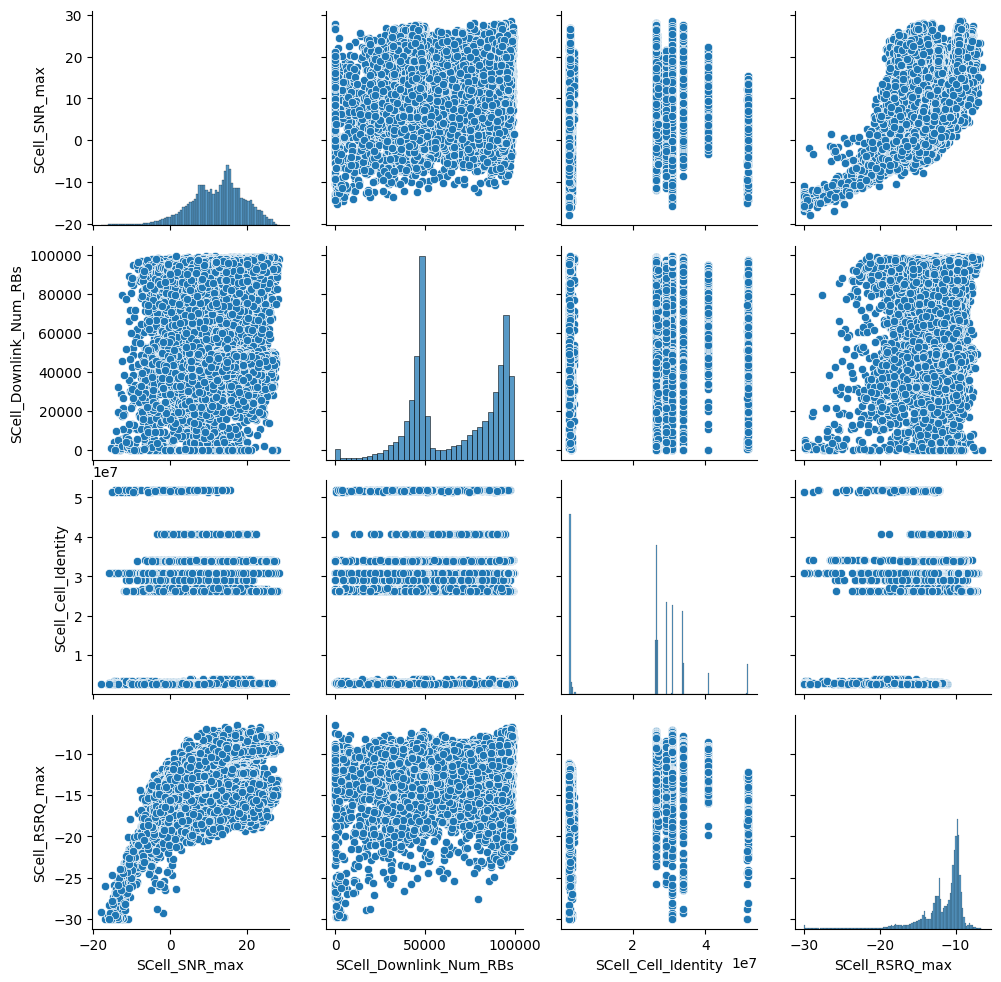

In [34]:
g = sns.PairGrid(data[['SCell_SNR_max','SCell_Downlink_Num_RBs','SCell_Cell_Identity','SCell_RSRQ_max']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

###Feature Engineering

In [223]:
data['N_PCell_RSRQ'] = data['PCell_RSRP_max'] / data['PCell_RSSI_max']
data['N_PCell_RSRP_Noise'] = data['PCell_RSRP_max'] / data['PCell_SNR_max']
data['N_PCell_RSRQ_Noise'] = data['PCell_RSRQ_max'] / data['PCell_SNR_max']
data['N_PCell_RSSI_Noise'] = data['PCell_RSSI_max'] / data['PCell_SNR_max']


In [224]:
data['N_SCell_RSRQ'] = data['SCell_RSRP_max'] / data['SCell_RSSI_max']
data['N_SCell_RSRP_Noise'] = data['SCell_RSRP_max'] / data['SCell_SNR_max']
data['N_SCell_RSRQ_Noise'] = data['SCell_RSRQ_max'] / data['SCell_SNR_max']
data['N_SCell_RSSI_Noise'] = data['SCell_RSSI_max'] / data['SCell_SNR_max']

In [225]:
def RSRmapper(rsr_col: pd.Series, h_bar: float, l_bar: float, colval: float) -> int:
  """
  This Function maps the values of a Referenced_Signal_Received(RSR) column
  to five different integer values between the intervals of h_bar(Highest possible value) and
  l_bar(Lowest possible Value) and returns the label for the colval

  Args:
   rsr_col : Referenced signal received column
   h_bar : Highest possible column value
   l_bar : Lowest possible column value
   colval : Column Value to turn into a interval label

  Returns:
   The Interval Label of the Column Value

  """

  common_diff = abs(h_bar - l_bar)/5
  if (h_bar-common_diff) <= colval <= h_bar :
    return 6
  elif (h_bar - 2*common_diff) <= colval <= (h_bar - common_diff):
    return 5
  elif (h_bar - 3*common_diff) <= colval <= (h_bar - 2*common_diff):
    return 4
  elif (h_bar - 4*common_diff) <= colval <= (h_bar - 3*common_diff):
    return 3
  elif (h_bar - 5*common_diff) <= colval <= (h_bar - 4*common_diff):
    return 2
  elif (h_bar - 6*common_diff) <= colval <= (h_bar - 5*common_diff):
    return 1
  else:
    return 0


In [226]:
# data['N_PCell_RSRP_max_bin'] = data['PCell_RSRP_max'].apply(lambda x: RSRmapper(rsr_col = data['PCell_RSRP_max'], h_bar=-40, l_bar=-140, colval=x))
# data['N_PCell_RSRQ_max_bin'] = data['PCell_RSRQ_max'].apply(lambda x: RSRmapper(rsr_col=data['PCell_RSRQ_max'], h_bar=-3, l_bar=-19.5, colval=x))
# data['N_PCell_RSSI_max_bin'] = data['PCell_RSSI_max'].apply(lambda x: RSRmapper(rsr_col=data['PCell_RSSI_max'], h_bar=0, l_bar=-120, colval=x))

In [227]:
data['N_PCell_RSRP_max_bin'] = pd.qcut(data['PCell_RSRP_max'],q=10,labels=False)
data['N_PCell_RSRQ_max_bin'] = pd.qcut(data['PCell_RSRQ_max'],q=10,labels=False)
data['N_PCell_RSSI_max_bin'] = pd.qcut(data['PCell_RSSI_max'],q=10,labels=False)

In [228]:
# data['N_SCell_RSRP_max_bin'] = data['SCell_RSRP_max'].apply(lambda x: RSRmapper(rsr_col = data['SCell_RSRP_max'], h_bar=-40, l_bar=-140, colval=x))
# data['N_SCell_RSRQ_max_bin'] = data['SCell_RSRQ_max'].apply(lambda x: RSRmapper(rsr_col=data['SCell_RSRQ_max'], h_bar=-3, l_bar=-19.5, colval=x))
# data['N_SCell_RSSI_max_bin'] = data['SCell_RSSI_max'].apply(lambda x: RSRmapper(rsr_col=data['SCell_RSSI_max'], h_bar=0, l_bar=-120, colval=x))

In [229]:
data['N_SCell_RSRP_max_bin'] = pd.qcut(data['SCell_RSRP_max'],q=10,labels=False)
data['N_SCell_RSRQ_max_bin'] = pd.qcut(data['SCell_RSRQ_max'],q=10,labels=False)
data['N_SCell_RSSI_max_bin'] = pd.qcut(data['SCell_RSSI_max'],q=10,labels=False)

In [230]:
train = data[data['target'] != 'Test'].copy()
test = data[data['target'] == 'Test'].copy()
test = test.drop(['target'],axis=1)
train['target'] = np.float64(train['target'])

In [231]:
TT = train.drop(['id','device'],axis=1)
tests = test.drop(['id','device'], axis=1)

categorical_features = ['area']
oe = OrdinalEncoder()
tests['area'] = oe.fit_transform(tests[['area']])
TT['area'] = oe.fit_transform(TT[['area']])


TT.fillna(0, inplace=True)
tests.fillna(0, inplace=True)

TT = TT[[col for col in TT.columns if col != 'target'] + ["target"]]

In [174]:
Baseline = Baseline_score(train=TT,model=cbc,split_method='train_test_split',num_split=5,VERBOSE=False,random_seed=0)
lgb_score = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

CV_RMSE_Score:9097508.044557989


In [443]:
NCell_scores_3 = []
pcols = np.array(TT.filter(like="PCell").columns)
scols = np.array(TT.filter(like="SCell").columns)
np.random.shuffle(pcols)
np.random.shuffle(scols)
r = r + 1
print(r)
print(pcols)
print(scols)

12
['N_PCell_RSSI_Noise' 'N_PCell_RSRQ_Noise' 'N_PCell_RSRQ_max_bin'
 'PCell_Cell_Identity' 'PCell_RSRP_max' 'PCell_RSSI_max' 'PCell_freq_MHz'
 'N_PCell_RSRP_Noise' 'PCell_SNR_max' 'PCell_RSRQ_max'
 'N_PCell_RSSI_max_bin' 'PCell_Downlink_bandwidth_MHz'
 'PCell_Downlink_Num_RBs' 'N_PCell_RSRQ' 'N_PCell_RSRP_max_bin'
 'PCell_Downlink_Average_MCS']
['SCell_freq_MHz' 'N_SCell_RSSI_Noise' 'SCell_SNR_max'
 'N_SCell_RSRP_Noise' 'SCell_RSSI_max' 'SCell_Downlink_Num_RBs'
 'N_SCell_RSSI_max_bin' 'N_SCell_RSRQ_Noise' 'SCell_RSRQ_max'
 'N_SCell_RSRQ_max_bin' 'SCell_Cell_Identity' 'N_SCell_RSRQ'
 'SCell_RSRP_max' 'SCell_Downlink_bandwidth_MHz'
 'SCell_Downlink_Average_MCS' 'N_SCell_RSRP_max_bin']


In [444]:
for i in range(0, len(pcols),4):
  cols = pcols[i:i+4]
  cols_ = scols[i:i+4]
  ncols = np.concatenate((cols,cols_))
  XY = TT[ncols].copy()
  XY['target'] = TT['target']

  Baseline = Baseline_score(train=XY,model=cbc,split_method='train_test_split',num_split=5,VERBOSE=False,random_seed=0)
  lgb_score = Baseline.run()
  NCell_scores_3.append(lgb_score)
  print(f"Cols_RMSE_Score:{' , '.join(ncols)}: {lgb_score}")

Cols_RMSE_Score:N_PCell_RSSI_Noise , N_PCell_RSRQ_Noise , N_PCell_RSRQ_max_bin , PCell_Cell_Identity , SCell_freq_MHz , N_SCell_RSSI_Noise , SCell_SNR_max , N_SCell_RSRP_Noise: 18381826.692226022
Cols_RMSE_Score:PCell_RSRP_max , PCell_RSSI_max , PCell_freq_MHz , N_PCell_RSRP_Noise , SCell_RSSI_max , SCell_Downlink_Num_RBs , N_SCell_RSSI_max_bin , N_SCell_RSRQ_Noise: 15024381.500880318
Cols_RMSE_Score:PCell_SNR_max , PCell_RSRQ_max , N_PCell_RSSI_max_bin , PCell_Downlink_bandwidth_MHz , SCell_RSRQ_max , N_SCell_RSRQ_max_bin , SCell_Cell_Identity , N_SCell_RSRQ: 17633320.288683485
Cols_RMSE_Score:PCell_Downlink_Num_RBs , N_PCell_RSRQ , N_PCell_RSRP_max_bin , PCell_Downlink_Average_MCS , SCell_RSRP_max , SCell_Downlink_bandwidth_MHz , SCell_Downlink_Average_MCS , N_SCell_RSRP_max_bin: 14356741.00838988
